In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

In [58]:
features = pd.read_csv('./data/TrainFeatures.csv')
outcome = pd.read_csv('./data/TrainOutcome.csv')

In [59]:
pd.isnull(features).any()

id                       False
amount_tsh               False
date_recorded            False
funder                    True
gps_height               False
installer                 True
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage                True
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting            True
recorded_by              False
scheme_management         True
scheme_name               True
permit                    True
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [60]:
features.shape

(59400, 40)

In [61]:
na_removed = features.dropna()
na_removed.shape

(27813, 40)

In [62]:
null_indices = features.columns[features.isna().any()].tolist()
for index in null_indices:
    mode = features[index].mode().iloc[0]
    features[index].loc[pd.isnull(features[index])] = mode
    
pd.isnull(features).any()

C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


id                       False
amount_tsh               False
date_recorded            False
funder                   False
gps_height               False
installer                False
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage               False
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting           False
recorded_by              False
scheme_management        False
scheme_name              False
permit                   False
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [63]:
categorical_indices = features.loc[:, features.dtypes == object].columns.values
continuous_indices = features.loc[:, features.dtypes != object].columns.values
categorical_indices

array(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'recorded_by',
       'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'], dtype=object)

In [64]:
continuous_indices

array(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'public_meeting', 'permit', 'construction_year'], dtype=object)

We need to disregard id since that will have no predictive power (as an arbitrarily assigned variable). We also need to correctly handle date_recorded by converting it into time since epoch. Region_code and district_code are incorrectly designated as continuous variables but that does not matter since our dependent variable is categorical and so we will be using chi-square tests to assess statistical significance.

In [65]:
# Removing date recorded (will handle later) and id
categorical_indices = categorical_indices[1:]
continuous_indices = continuous_indices[1:]

transformed_features = features.copy();
transformed_features

# Dropping waterpoint name
transformed_features = transformed_features.drop('wpt_name', axis=1)

for index in categorical_indices:
    transformed_features[index] = features[index].replace(features[index].unique(), np.arange(len(features[index].unique()))).astype('int')
    print("done with " + index)

done with funder
done with installer
done with wpt_name
done with basin
done with subvillage
done with region
done with lga
done with ward
done with recorded_by
done with scheme_management
done with scheme_name
done with extraction_type
done with extraction_type_group
done with extraction_type_class
done with management
done with management_group
done with payment
done with payment_type
done with water_quality
done with quality_group
done with quantity
done with quantity_group
done with source
done with source_type
done with source_class
done with waterpoint_type
done with waterpoint_type_group


In [66]:
categorical_outcome = outcome['status_group']
categorical_outcome = categorical_outcome.replace(['functional', 'functional needs repair', 'non functional'], [0, 1, 2]).astype('int')
categorical_outcome

0        0
1        0
2        0
3        2
4        0
5        0
6        2
7        2
8        2
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       2
17       2
18       1
19       0
20       0
21       0
22       1
23       0
24       0
25       1
26       0
27       0
28       2
29       0
        ..
59370    0
59371    2
59372    2
59373    0
59374    0
59375    0
59376    2
59377    2
59378    0
59379    0
59380    2
59381    2
59382    2
59383    0
59384    2
59385    0
59386    0
59387    0
59388    0
59389    0
59390    0
59391    2
59392    2
59393    0
59394    2
59395    0
59396    0
59397    0
59398    0
59399    0
Name: status_group, Length: 59400, dtype: int32

In [67]:
# Converting date_recorded to time since epoch
epoch_time = []

for date in features['date_recorded']:
    date = datetime.strptime(date, '%Y-%m-%d')
    epoch_time.append(date.timestamp())
    
transformed_features['date_recorded'] = epoch_time

In [68]:
for index in categorical_indices:
    table = pd.crosstab(transformed_features[index], categorical_outcome)
    c, p, dof, expected = chi2_contingency(table.values)
    print(index + ': ' + str(p))
    
for index in continuous_indices:
    table = pd.crosstab(transformed_features[index], categorical_outcome)
    c, p, dof, expected = chi2_contingency(table.values)
    print(index + ': ' + str(p))

funder: 0.0
installer: 0.0
wpt_name: 3.167496602060987e-15
basin: 0.0
subvillage: 0.0
region: 0.0
lga: 0.0
ward: 0.0
recorded_by: 1.0
scheme_management: 0.0
scheme_name: 0.0
extraction_type: 0.0
extraction_type_group: 0.0
extraction_type_class: 0.0
management: 0.0
management_group: 1.7446261385259768e-57
payment: 0.0
payment_type: 0.0
water_quality: 0.0
quality_group: 0.0
quantity: 0.0
quantity_group: 0.0
source: 0.0
source_type: 0.0
source_class: 1.983538119535752e-126
waterpoint_type: 0.0
waterpoint_type_group: 0.0
amount_tsh: 0.0
gps_height: 1.935832234019064e-40
longitude: 0.9999988241305058
latitude: 0.9999988211760183
num_private: 1.3700364563899945e-12
region_code: 0.0
district_code: 0.0
population: 1.2004595650770784e-174
public_meeting: 6.695873894822635e-63
permit: 1.5416464629999488e-15
construction_year: 0.0


Features that have a statistically significant difference with water pump condition:

- wpt name
- public meeting
- permit
- management group
- source class
- gps height
- num private
- population

wpt_name is the name of the water pump so we will not use that.

In [69]:
column_selector = ['public_meeting', 'permit', 'management_group', 'source_class', 'gps_height', 'num_private', 'population']

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count of Occurrences')

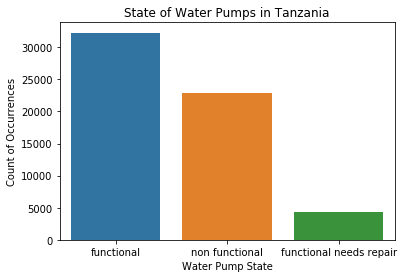

In [70]:
fig, ax = plt.subplots()
fig = sns.countplot(x="status_group", data=outcome)
ax.set_title('State of Water Pumps in Tanzania')
ax.set_xlabel('Water Pump State')
ax.set_ylabel('Count of Occurrences')

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count of Occurrences')

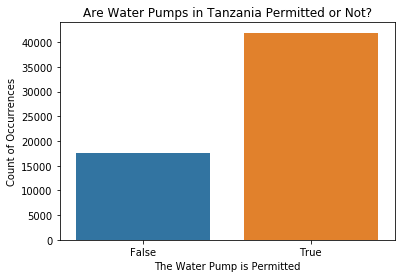

In [71]:
fig, ax = plt.subplots()
fig = sns.countplot(x="permit", data=features)
ax.set_title('Are Water Pumps in Tanzania Permitted or Not?')
ax.set_xlabel('The Water Pump is Permitted')
ax.set_ylabel('Count of Occurrences')

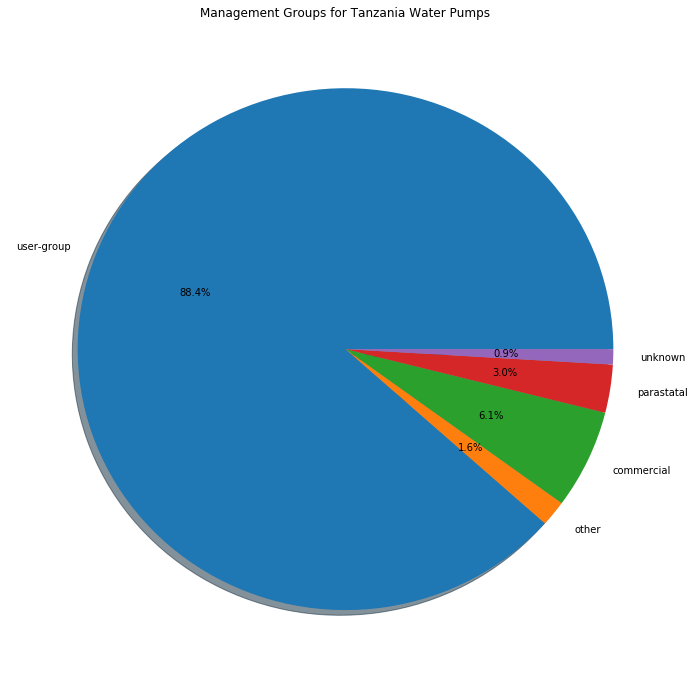

In [72]:
groups = features['management_group'].unique()
sizes = []
for group in groups:
    sizes.append(len(features.loc[features['management_group'] == group]))
fig, ax = plt.subplots()
plt.pie(sizes, labels=groups, autopct='%1.1f%%', shadow=True)
ax.set_title('Management Groups for Tanzania Water Pumps')
fig.set_size_inches(12,12)

parastatal: separate from the government but activities serve the government

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count of Occurrences')

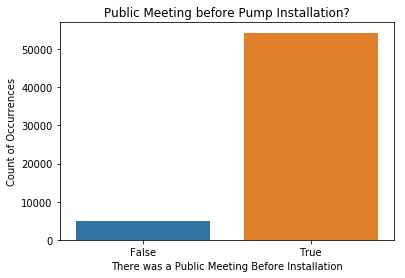

In [73]:
fig, ax = plt.subplots()
fig = sns.countplot(x="public_meeting", data=features)
ax.set_title('Public Meeting before Pump Installation?')
ax.set_xlabel('There was a Public Meeting Before Installation')
ax.set_ylabel('Count of Occurrences')

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count of Occurrences')

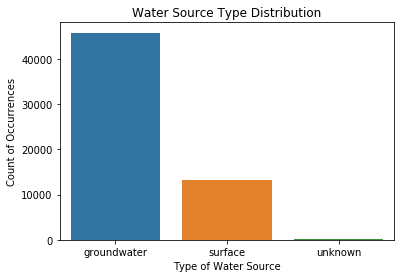

In [74]:
fig, ax = plt.subplots()
fig = sns.countplot(x="source_class", data=features)
ax.set_title('Water Source Type Distribution')
ax.set_xlabel('Type of Water Source')
ax.set_ylabel('Count of Occurrences')

Text(0,0.5,'Population around Water Pump')

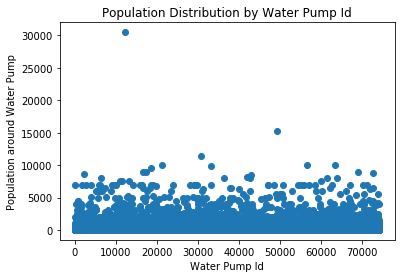

In [75]:
fig, ax = plt.subplots()
fig = plt.scatter(x="id", y="population", data=features)
ax.set_title('Population Distribution by Water Pump Id')
ax.set_xlabel('Water Pump Id')
ax.set_ylabel('Population around Water Pump')

Text(0,0.5,'Private Water Pumps around Water Pump')

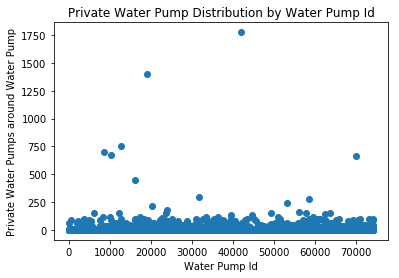

In [76]:
fig, ax = plt.subplots()
fig = plt.scatter(x="id", y="num_private", data=features)
ax.set_title('Private Water Pump Distribution by Water Pump Id')
ax.set_xlabel('Water Pump Id')
ax.set_ylabel('Private Water Pumps around Water Pump')

In [77]:
train_features, test_features, train_outcome, test_outcome = train_test_split(
    transformed_features, # [column_selector]
    categorical_outcome,
    test_size=0.30
)

In [78]:
param_grid = {'criterion': ['gini', 'entropy']}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="accuracy") 

In [79]:
grid.fit(train_features, train_outcome)
grid.score(test_features, test_outcome)

0.7369809203142537

In [80]:
grid.best_params_

{'criterion': 'entropy'}

In [81]:
tree_test_predict = grid.predict(test_features)

In [82]:
param_grid2 = {'n_neighbors':range(1, 11), 'weights': ['uniform', 'distance']}

grid2 = GridSearchCV(KNeighborsClassifier(), param_grid2, scoring="accuracy") 

In [83]:
grid2.fit(train_features, train_outcome)
grid2.score(test_features, test_outcome)

0.5395622895622896

In [84]:
grid2.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

In [85]:
knn_test_predict = grid2.predict(test_features)

It looks like the decision tree classifier does a lot better than the k nearest neighbors classifier.

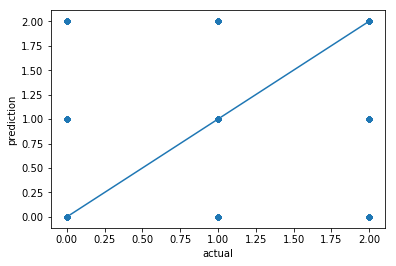

In [86]:
test_features = pd.DataFrame(test_features)
test_features['prediction'] = tree_test_predict
test_features['actual'] = test_outcome

test_features.plot('actual', 'prediction', kind='scatter')
plt.plot(test_features.actual, test_features.actual)
plt.show()

In [87]:
test_features['err'] = test_features['prediction'] - test_features['actual']

C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\james\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


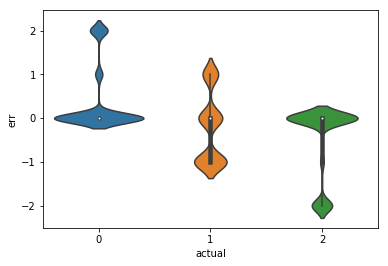

In [88]:
sns.violinplot(test_features['actual'], test_features['err'])

In [90]:
feature_selector = RFECV(estimator=DecisionTreeClassifier(criterion='entropy'), step=1, scoring="accuracy").fit(transformed_features, categorical_outcome)
columns = feature_selector.get_support(indices=True)
colnames = transformed_features.columns[columns]

transformed_features = transformed_features[colnames]

In [91]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(transformed_features, categorical_outcome)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [93]:
test_features = pd.read_csv('./data/TestFeatures.csv')

test_features = test_features[colnames]

We need to handle nulls and convert categorical data and dates to integers again.

In [94]:
null_indices = test_features.columns[test_features.isna().any()].tolist()
for index in null_indices:
    mode = test_features[index].mode().iloc[0]
    test_features[index].loc[pd.isnull(test_features[index])] = mode
    
# Converting date_recorded to time since epoch
epoch_time = []

for date in test_features['date_recorded']:
    date = datetime.strptime(date, '%Y-%m-%d')
    epoch_time.append(date.timestamp())
    
test_features['date_recorded'] = epoch_time
    
categorical_indices = test_features.loc[:, test_features.dtypes == object].columns.values

for index in categorical_indices:
    test_features[index] = test_features[index].replace(test_features[index].unique(), np.arange(len(test_features[index].unique()))).astype('int')
    print("done with " + index)

done with funder
done with installer
done with basin
done with subvillage
done with region
done with lga
done with ward
done with scheme_name
done with extraction_type
done with extraction_type_group
done with extraction_type_class
done with management
done with payment
done with payment_type
done with quantity
done with quantity_group
done with source
done with source_type
done with waterpoint_type
done with waterpoint_type_group
done with wpt_name


In [95]:
predictions = clf.predict(test_features)

test_outcome = pd.read_csv('./data/SubmissionFormat.csv')
test_outcome['status_group'] = predictions
test_outcome['status_group'] = test_outcome['status_group'].replace([0, 1, 2], ['functional', 'functional needs repair', 'non functional'])

test_outcome.to_csv('./data/Submission.csv', index=False)